### Imports e Configuração da Métrica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(f"Shape Treino: {train.shape}")
print(f"Shape Teste: {test.shape}")

Shape Treino: (1460, 80)
Shape Teste: (1459, 79)


### Transformação do Target e Remoção de Outliers


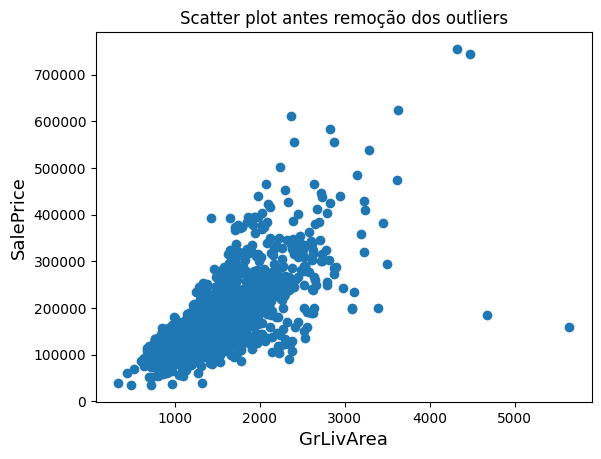

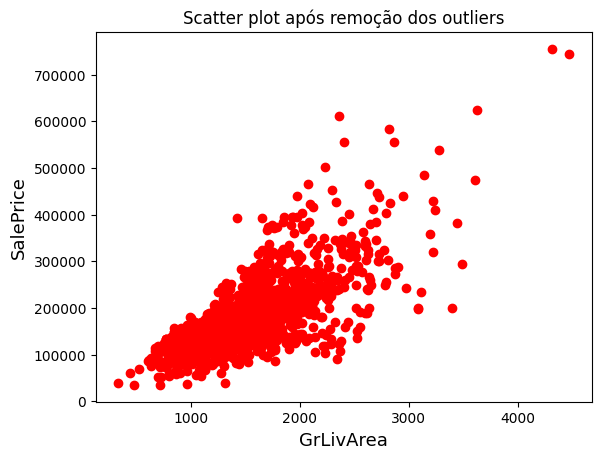

Dados concatenados shape: (2917, 79)


In [2]:
# Removendo Outliers 
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("Scatter plot antes remoção dos outliers")
plt.show()

# Removendo
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Plot após remoção
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], color='red')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("Scatter plot após remoção dos outliers")
plt.show()

# Transformação Logarítmica do Target
train["SalePrice"] = np.log1p(train["SalePrice"])

# Concatenar dados para pré-processamento unificado
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print(f"Dados concatenados shape: {all_data.shape}")

### Limpeza de Nulos (Domain Knowledge)

In [3]:
# Variáveis onde NA significa "Ausência da Categoria" 
cols_na_means_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
]

for col in cols_na_means_none:
    all_data[col] = all_data[col].fillna('None')

# Variáveis Numéricas onde NA significa 0 
cols_na_means_zero = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
]

for col in cols_na_means_zero:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage 
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Ajustes Finais 
cols_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) 

# Se PoolQC é None, PoolArea é 0.
all_data["PoolArea"] = all_data["PoolArea"].fillna(0)
all_data["MiscVal"] = all_data["MiscVal"].fillna(0)

# Preenchimento pela Moda (AllPub)
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])

total_missing = all_data.isnull().sum().sum()
print(f"Total de valores faltantes agora: {total_missing}")

if total_missing > 0:
    print(all_data.isnull().sum()[all_data.isnull().sum() > 0])
else:
    print("✅ O Dataset está limpo e pronto para Feature Engineering.")

Total de valores faltantes agora: 0
✅ O Dataset está limpo e pronto para Feature Engineering.


### Feature Engineering

In [4]:
# CORREÇÃO DE SEMÂNTICA (Numérico -> Categórico)
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


# LABEL ENCODING 
# Estas variáveis têm uma ordem implícita (ex: Ruim < Médio < Bom)
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 
        'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 
        'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 
        'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Aplicamos LabelEncoder para converter texto em números 
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print(f'Shape após Label Encoding: {all_data.shape}')


# CRIAÇÃO DE FEATURES
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# SKEWNESS 
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Calculamos a assimetria (skew) de todas as numéricas
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nTop 10 Variáveis com maior Assimetria (Skew):")
print(skewed_feats.head(10))

# Filtramos as que têm skew alto (> 0.75) para tratar
skewness = skewed_feats[abs(skewed_feats) > 0.75]
print(f"\nTotal de variáveis numéricas 'tortas' para corrigir: {skewness.shape[0]}")

# Aplicamos a Transformação Box-Cox
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
print("✅ Correção de Skewness (Box-Cox) aplicada.")


# One-Hot Encoding final
all_data = pd.get_dummies(all_data)
print(f"\nShape Final do Dataset: {all_data.shape}")

Shape após Label Encoding: (2917, 79)

Top 10 Variáveis com maior Assimetria (Skew):
MiscVal          21.939672
PoolArea         17.688664
HasPool          15.494756
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
LandSlope         4.973254
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
dtype: float64

Total de variáveis numéricas 'tortas' para corrigir: 39
✅ Correção de Skewness (Box-Cox) aplicada.

Shape Final do Dataset: (2917, 229)


### Configuração dos Modelos Base

In [5]:
train = all_data[:ntrain]
test = all_data[ntrain:]
y_train = train_ID 

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

print("Setup de Validação pronto.")

Setup de Validação pronto.


#### Definição dos Modelos

In [6]:
# 1. LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# 2. Elastic Net
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# 3. Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# 4. Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# 5. XGBoost 
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# 6. LightGBM 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

print("Modelos definidos e carregados.")

Modelos definidos e carregados.


### Resultados (Baseline)

In [7]:
# Recarregamos o dado bruto temporariamente apenas para pegar o preço
train_raw = pd.read_csv('./data/train.csv')

train_raw = train_raw.drop(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<300000)].index)
y_train = np.log1p(train_raw["SalePrice"]).values

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1101 (0.0073)

ElasticNet score: 0.1101 (0.0074)

Kernel Ridge score: 0.1800 (0.0061)

Gradient Boosting score: 0.1155 (0.0081)

XGBoost score: 0.1142 (0.0063)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored.

### Stacking

In [8]:

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                
                # Treina nos folds de treino
                instance.fit(X[train_index], y[train_index])
                
                # Preve no fold de teste (holdout)
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Agora treinamos o Meta-Modelo usando as previsões dos modelos base como features
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Fazemos a previsão final rodando todos os modelos base e passando pro meta
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

print("Classe de Stacking definida.")

# Definindo o Stacking
stacked_averaged_models = StackingAveragedModels(
    base_models = (ENet, GBoost, KRR),
    meta_model = lasso
)

# Avaliando o Score do Stacking
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged Models Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Classe de Stacking definida.
Stacking Averaged Models Score: 0.1075 (0.0074)


### Predição e Submissão (Blending)

In [9]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

print("Treinando modelos finais em todo o dataset...")

# Stacking
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values)) # expm1 inverte o log1p
print("Stacking treinado.")

# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print("XGBoost treinado.")

# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print("LightGBM treinado.")

# O BLEND 
# Stacking (70%) + XGB (15%) + LGB (15%)
weight_stack = 0.70
weight_xgb = 0.15
weight_lgb = 0.15

print(f"\nRMSE no Treino (Check de Overfitting):")
print(rmsle(y_train, stacked_train_pred * weight_stack + 
               xgb_train_pred * weight_xgb + 
               lgb_train_pred * weight_lgb))

# Geração do Arquivo de Submissão
ensemble = stacked_pred * weight_stack + xgb_pred * weight_xgb + lgb_pred * weight_lgb

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_dswa.csv', index=False)

print("\n✅ Arquivo 'submission_dswa.csv' gerado com sucesso!")
print("Estamos prontos para subir no Leaderboard.")

Treinando modelos finais em todo o dataset...
Stacking treinado.
XGBoost treinado.
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value